In [ ]:
!pip install -U -q PyDrive  ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [ ]:
csv_import = drive.CreateFile({'id': '1sjdocot79ixGtJG9Bq9rLtL_GA1DyFwq'})
csv_import.GetContentFile('final_merged_dataset.csv')


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
% matplotlib inline
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())


In [ ]:
class DARNN(object):
    def __init__(self, input_dim, time_step, e_hidden, d_hidden, o_hidden, batch_size):
        self.batch_size = batch_size
        self.e_hidden = e_hidden
        self.d_hidden = d_hidden
        self.o_hidden = o_hidden
        self.input_dim = input_dim
        self.time_step = time_step

        self.seq_len = tf.placeholder(tf.int32, [None])

        # Creating placeholders for input x, input y, labels
        # Input X -> batch_size * T * d
        # Input Y -> batch_size * T (target series)
        # n are the number of driving series
        # T is the window size
        self.input_x = tf.placeholder(dtype=tf.float32, shape=[None, None, self.input_dim], name='Input_X')
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None, self.time_step], name='Input_Y')
        self.label = tf.placeholder(dtype=tf.float32)

        # Creating cells for encoder, decoder
        self.encode_cell = tf.contrib.rnn.LSTMCell(self.e_hidden, forget_bias=1.0, state_is_tuple=True)
        self.decode_cell = tf.contrib.rnn.LSTMCell(self.d_hidden, forget_bias=1.0, state_is_tuple=True)
        self.output_cell = tf.contrib.rnn.LSTMCell(self.o_hidden, forget_bias=1.0, state_is_tuple=True)

        # Initializing loss
        self.loss = tf.constant(0.0, name='Loss')

        ##############################################################################################
        # Building the model - https://arxiv.org/pdf/1704.02971.pdf
        #############################################################################################

        ##############ENCODER##############
        out = self.encoder_rnn(self.input_x)
        self.out = out  # b * T * 2*e_hidden
        out = tf.transpose(out, [0, 2, 1], name='transpose_line_36')  # b * 2*e_hidden *T
        with tf.name_scope('encoder') as scope:
            stddev = 1.0 / (self.e_hidden * self.time_step)
            Ue = tf.Variable(dtype=tf.float32,
                             initial_value=tf.truncated_normal(shape=[self.time_step, self.time_step],
                                                               mean=0.0, stddev=stddev),
                             name='Ue')
        var = tf.tile(tf.expand_dims(Ue, 0), [self.batch_size, 1, 1], name='tile_Ue')  # b*T*T
        batch_mul = tf.matmul(var, self.input_x,
                              name='matmul_line44')  # (b*T*T)*(b*T*d) = (b,T,d)--UeXk component of Eq8, d is number of dims
        self.out = batch_mul
        e_list = []

        for k in range(self.input_dim):
            series_k = tf.reshape(batch_mul[:, :, k], [self.batch_size, self.time_step, 1],
                                  name='reshape_line49')  # b T 1
            e_k = self.attention(out, series_k, scope='encoder')  # calculating eq 8
            e_list.append(e_k)
        e_list = tf.concat(e_list, axis=1)
        soft_attention = tf.nn.softmax(e_list, dim=1, name='softmax_line53')  # b d T
        input_attention = tf.multiply(self.input_x, tf.transpose(soft_attention, [0, 2, 1]),
                                      name='multiply_line54')  # b T d

        with tf.variable_scope('fw_lstm') as scope:
            tf.get_variable_scope().reuse_variables()
            h, _ = tf.nn.dynamic_rnn(self.encode_cell, input_attention, self.seq_len,
                                     dtype=tf.float32)
            # h : b T eh

        #############DECODER############
        d, dec_out = self.decoder_rnn(h)  # d: b, T ,dh dec_out: b T 2dh
        self.out = d
        dec_out = tf.transpose(dec_out, [0, 2, 1], name='transpose_line65')
        with tf.name_scope('decoder') as scope:
            stddev = 1. / (self.d_hidden * self.time_step)  ## it should be e_hidden * time_step
            Ud = tf.Variable(dtype=tf.float32,
                             initial_value=tf.truncated_normal(shape=[self.e_hidden,
                                                                      self.e_hidden],
                                                               mean=0.0,
                                                               stddev=stddev,
                                                               ), name='Ud')

        de_var = tf.tile(tf.expand_dims(Ud, 0), [self.batch_size, 1, 1], name='tile_line76')  # b, eh, eh
        batch_mul_de = tf.matmul(h, de_var, name='matmul_line77')  # b T eh * b eh eh = b T eh
        batch_mul_de = tf.transpose(batch_mul_de, [0, 2, 1], name='transpose_line78')  # b eh T
        e_de_list = []
        for t in range(self.time_step):
            series_t = tf.reshape(batch_mul_de[:, :, t], [self.batch_size, self.e_hidden, 1], name='reshape_line81')
            e_t = self.de_attention(dec_out, series_t, scope='decoder')
            e_de_list.append(e_t)
        e_de_list = tf.concat(e_de_list, axis=1, name='concat_line84')  # b T T 
        de_soft_attention = tf.nn.softmax(e_de_list, dim=1, name='softmax_line85')  # sames dims as e_de_list

        #######################CONTEXT#########################
        c_list = []
        for t in range(self.time_step):
            Beta_t = tf.expand_dims(de_soft_attention[:, :, t], -1, name='expand_line90')  # b T 1
            weighted = tf.reduce_sum(tf.multiply(Beta_t, h), 1,
                                     name='reducesum_line91')  # b T 1 . b T eh = reducesum(b T eh) = b eh
            c_list.append(tf.expand_dims(weighted, 1, name='expand_line92'))  # b 1 eh
        c_t = tf.concat(c_list, axis=1, name='concat_line93')  ## b T eh
        self.out = c_t
        # concat - b T 1 & b T eh = b T eh+1
        c_t_hat = tf.concat([tf.expand_dims(self.input_y, -1), c_t], axis=2,
                            name='concat_line95')  # b, T, (eh+1) where +1 is for concatenation

        ####################Y_Hat##############################

        with tf.variable_scope('temporal'):
            mean = 0.0
            stddev = 1. / (self.e_hidden * self.time_step)
            W_hat = tf.get_variable(name='W_hat', shape=[self.e_hidden + 1, 1], dtype=tf.float32,
                                    initializer=tf.truncated_normal_initializer(mean, stddev))
        W_o = tf.tile(tf.expand_dims(W_hat, 0), [self.batch_size, 1, 1], name='tile_line104')
        y_hat = tf.matmul(c_t_hat, W_o, name='matmul_line105')  # b T 1+eh X b 1+eh 1 = b T 1

        ################Final Step###########################

        d_y_concat = tf.concat([d, y_hat], axis=2, name='concat_line110')  ## b T dh+1
        with tf.variable_scope('out_lstm') as scope:
            d_final, _ = tf.nn.dynamic_rnn(self.output_cell, d_y_concat, self.seq_len, dtype=tf.float32)  # b T o_hidden

        ##############Output Y_t ##########################
        d_c_concat = tf.concat([d_final[:, -1, :], c_t[:, -1, :]], axis=1, name='concat_line116')  # b, oh+eh
        d_c_concat = tf.expand_dims(d_c_concat, -1, name='expand_line117')  # b,oh+eh,1

        with tf.variable_scope('predict'):
            mean = 0.0
            stddev = 1.0 / (self.e_hidden * self.time_step)
            Wy = tf.get_variable(name='Wy', shape=[self.o_hidden, self.o_hidden + self.e_hidden], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(mean, stddev))
            Vy = tf.get_variable(name='Vy', shape=[self.o_hidden], dtype=tf.float32,
                                 initializer=tf.truncated_normal_initializer(mean, stddev))
            bw = tf.get_variable(name='bw', shape=[self.o_hidden], dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        W_y = tf.tile(tf.expand_dims(Wy, 0), [self.batch_size, 1, 1], name='tile_line128')  # b,oh,oh+eh
        b_w = tf.expand_dims(tf.tile(tf.expand_dims(bw, 0), [self.batch_size, 1]), -1,
                             name='expand_line129')  # b,oh -> b,oh,1
        V_y = tf.tile(tf.expand_dims(Vy, 0), [self.batch_size, 1], name='tile_line130')  # b,oh
        V_y = tf.expand_dims(V_y, 1, name='expand_line131')  # b,1,oh
        self.y_predict = tf.squeeze(tf.matmul(V_y, tf.matmul(W_y, d_c_concat) + b_w),
                                    name='squeeze_line132')  # (b,1,oh) * (b,oh,1) -> squeeze -> (b,)

        self.loss += tf.reduce_mean(tf.square(self.label - self.y_predict), name='reduce_mean_line134')
        self.params = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(1e-3)
        # self.train_op = optimizer.minimize(self.loss)  ~ compute_gradients + apply_gradients
        grad_var = optimizer.compute_gradients(loss=self.loss, var_list=self.params, aggregation_method=2)
        self.train_op = optimizer.apply_gradients(grad_var, name='apply_gradients_line139')



    def encoder_rnn(self, input_x):
        with tf.variable_scope('fw_lstm') as scope:
            # In Dynamic RNN we get a dynamic graph based on the input length
            # This is known to be as fast as it's static counterpart
            # Since our encoded cell is an LSTM cell, it return a LSTMStateTuple (ct, mt)
            # c -> cell state of LSTM cell
            # m ->  output of LSTM cell
            # out -> Output of the unrolled RNN ([batch_size * T * hidden_units])
            # states -> 'state' is a N-tuple, where N is the number of LSTMCells, containing a
            # tf.contrib.rnn.LSTMStateTuple for each cell - (c, h) c = hidden state, h = output of LSTM (or c, m)
            # here we only have a single state because there is just 1 LSTM cell passes into dynamic_rnn
            out, state = tf.nn.dynamic_rnn(self.encode_cell, input_x, self.seq_len, dtype=tf.float32)
            state = tf.Print(state, [state, tf.shape(state)], "These are the fucking states")
        tmp = tf.tile(state[0], [1, self.time_step], name='tile_encoder_rnn')
        tmp = tf.reshape(tmp, [self.batch_size, self.time_step, self.e_hidden], name='reshape_encoder_rnn')
        concat = tf.concat([out, tmp], axis=2, name='concat_encoder_rnn')
        # According to the paper - out -> h and tmp -> s
        # So my interpretation is that out is actaully the output of the LSTM i.e. m in LSTM paper
        # or h in tensorflow or h in DARNN paper. And state is the (c,h) or (s,h) --- so shouldn't we use 
        # state[0]
        return concat  ## shape should be (b, T, 2*e_hidden) 

    def decoder_rnn(self, h):
        with tf.variable_scope('dec_lstm') as scope:
            cell = self.decode_cell
            d, s = tf.nn.dynamic_rnn(self.decode_cell, h, self.seq_len, dtype=tf.float32)
        tmp = tf.tile(s[0], [1, self.time_step], name='tile_decoder_rnn')
        tmp = tf.reshape(tmp, [self.batch_size, self.time_step, self.d_hidden], name='reshape_decoder_rnn')
        concat = tf.concat([d, tmp], axis=2, name='concat_decoder_rnn')  # b T 2*d_hidden
        return d, concat


    def attention(self, out, series_k, scope=None):
        with tf.variable_scope('encoder') as scope:
            try:
                mean = 0.
                stddev = 1. / (self.e_hidden * self.time_step)
                # See Eq 8
                We = tf.get_variable(name='We', dtype=tf.float32, shape=[self.time_step, 2 * self.e_hidden],
                                     initializer=tf.truncated_normal_initializer(mean, stddev))
                Ve = tf.get_variable(name='Ve', dtype=tf.float32, shape=[1, self.time_step],
                                     initializer=tf.truncated_normal_initializer(mean, stddev))
            except ValueError:
                scope.reuse_variables()
                We = tf.get_variable('We')
                Ve = tf.get_variable('Ve')
        We = tf.tile(tf.expand_dims(We, 0), [self.batch_size, 1, 1], name='tile_attention')
        brcast = tf.nn.tanh(tf.matmul(We, out) + series_k,
                            name='tanh_attention')  # b * T * 2eh X b * 2eh * T + b * T * 1 = b T T
        V_e = tf.tile(tf.expand_dims(Ve, 0), [self.batch_size, 1, 1], name='tile_attention')  # b 1 T
        return tf.matmul(V_e, brcast, name='matmul_attention')  # b 1 T


    def de_attention(self, out, series_k, scope='None'):
        with tf.variable_scope('decoder') as scope:
            try:
                mean = 0.
                stddev = 1.0 / (self.d_hidden * self.time_step)
                Wd = tf.get_variable(name='Wd', dtype=tf.float32, shape=[self.e_hidden, 2 * self.d_hidden],
                                     initializer=tf.truncated_normal_initializer(mean, stddev))
                Vd = tf.get_variable(name='Vd', dtype=tf.float32, shape=[1, self.e_hidden],
                                     initializer=tf.truncated_normal_initializer(mean, stddev))

            except ValueError as e:
                scope.reuse_variables()
                Wd = tf.get_variable('Wd')
                Vd = tf.get_variable('Vd')
        W_d = tf.tile(tf.expand_dims(Wd, 0), [self.batch_size, 1, 1], name='Wd_tile_de_attention')
        brcast = tf.nn.tanh(tf.matmul(W_d, out) + series_k,
                            name='tanh_de_attention')  # b eh 2dh * b 2dh T + b eh 1(T) = b eh T
        V_d = tf.tile(tf.expand_dims(Vd, 0), [self.batch_size, 1, 1], name='Vd_tile_de_attention')  # b 1 eh
        return tf.matmul(V_d, brcast, name='matmul_de_attention')  # b 1 eh * b eh T = b 1 T

    def predict(self, x_test, y_test, sess):
        train_seq_len = np.ones(self.batch_size) * self.time_step
        feed = {
            model.input_x: x_test,
            model.input_y: y_test,
            model.seq_len: train_seq_len,
        }
        y_hat = sess.run(self.y_predict, feed_dict=feed)
        return y_hat


In [136]:
import os

os.getcwd()
df = pd.read_csv('final_merged_dataset.csv')
df.describe()
df.columns
df_i = df[[u'EMA', u'RSI', u'BBANDS', u'SENTIDX', u'ADX', u'MACD',
           u'SMA', u'Close', u'Volume']]
df_i.describe()


,EMA,RSI,BBANDS,SENTIDX,ADX,MACD,SMA,Close,Volume
count,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1.179000e+03
mean,332.849619,45.006467,333.385095,3.903623,20.251436,-4.785198,333.385095,87.100047,7.709930e+07
std,193.761282,9.315510,198.349459,3.573434,9.956991,20.787668,198.349459,23.061460,4.420658e+07
min,111.949700,22.927400,95.768700,-8.492248,5.425400,-139.993100,95.768700,50.928800,1.304644e+07
25%,121.845667,41.788800,117.289200,2.083522,13.857200,-4.756700,117.289200,67.264367,4.759360e+07
50%,432.071300,46.749500,433.033400,3.130212,18.990600,-0.338233,433.033400,83.905451,6.436920e+07
75%,521.874500,50.722025,521.932800,4.616411,22.991712,2.125800,521.932800,108.744376,9.341745e+07
max,647.561100,64.277800,654.244900,57.715096,42.542400,19.050800,654.244900,126.931724,3.652131e+08


In [ ]:
scalar = MinMaxScaler((0, 1))
def get_batch(df, batch_size=128, T=24, input_dim=9, step=0, train=True):
    t = step * batch_size
    try:
        X_batch = np.empty(shape=[batch_size, T, input_dim])
        Y_batch = np.empty(shape=[batch_size, T])
        labels = np.empty(shape=[batch_size])
    except Exception as e:
        print type(batch_size), type(T), type(input_dim)
        raise

    for i in range(batch_size):
        #print t 
        X_batch[i, :] = scalar.fit_transform(df.iloc[t:t + T].values)
        Y_batch[i, :] = df['Close'].iloc[t:t + T].values
        labels[i] = df['Close'].iloc[t + T]
        t += 1

    ##Shuffle train, not test
    if train:
        index = range(batch_size)
        np.random.shuffle(index)
        X_batch = X_batch[index]
        Y_batch = Y_batch[index]
        labels = labels[index]

    return X_batch, Y_batch, labels


In [ ]:
batch_size = 128
train_batch_num = int(len(df_i) * 0.85 / batch_size)
df_test = df_i[(train_batch_num * batch_size):]
df_i = df_i[:(train_batch_num * batch_size) + 65]


In [101]:
batch_size = 128
input_dim = 9  #9 input features
time_step = 30
e_hidden = 128
d_hidden = 64
o_hidden = 16

current_episode = 0
total_episodes = 1000
steps = int(len(df_i) / batch_size)

tf.reset_default_graph()
model = DARNN(input_dim=input_dim, time_step=time_step, e_hidden=e_hidden, d_hidden=d_hidden, o_hidden=o_hidden,
              batch_size=batch_size)
init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess.run(init)

while current_episode <= total_episodes:
    cumulative_loss = 0.
    for t in range(steps):
        x, y, labels = get_batch(df_i, batch_size=batch_size, T=time_step, step=t)
        train_seq_len = np.ones(batch_size) * time_step
        feed = {
            model.input_x: x,
            model.seq_len: train_seq_len,
            model.input_y: y,
            model.label: labels
        }
        loss, _ = sess.run([model.loss, model.train_op], feed_dict=feed)
        cumulative_loss += loss
        if t % 5 == 0:
            print("Current episode %i, steps %i, losses are %f" % (current_episode, t, cumulative_loss))
            cumulative_loss = 0.
    current_episode += 1


Current episode 0, steps 0, losses are 4196.734375
Current episode 0, steps 5, losses are 29941.208740
Current episode 1, steps 0, losses are 4194.832031
Current episode 1, steps 5, losses are 29913.606689
Current episode 2, steps 0, losses are 4178.653809
Current episode 2, steps 5, losses are 29701.306641
Current episode 3, steps 0, losses are 4114.239746
Current episode 3, steps 5, losses are 29161.621338
Current episode 4, steps 0, losses are 3992.086914
Current episode 4, steps 5, losses are 28291.134766
Current episode 5, steps 0, losses are 3816.833008
Current episode 5, steps 5, losses are 27110.239258
Current episode 6, steps 0, losses are 3590.016357
Current episode 6, steps 5, losses are 25619.598633
Current episode 7, steps 0, losses are 3313.614258
Current episode 7, steps 5, losses are 23834.353271
Current episode 8, steps 0, losses are 2993.246582
Current episode 8, steps 5, losses are 21791.581055
Current episode 9, steps 0, losses are 2638.379883
Current episode 9, ste

In [122]:
test_batch_num = int(len(df_test) / batch_size)
test_loss = 0.0
y_hat_arr = np.empty(shape=[0])
y_labels_arr = np.empty(shape=[0])

for t in range(test_batch_num - 1):
    x_test, y_test, labels_test = get_batch(df_test, batch_size=batch_size, T=time_step, step=t, train=False)
    y_hat = model.predict(x_test, y_test, sess)
    y_hat_arr = np.concatenate([y_hat_arr, np.array(y_hat)])
    y_labels_arr = np.concatenate([y_labels_arr, labels_test])
    test_loss += np.mean(np.square(y_hat - labels_test))
print("Mean squared error for test data is %f" % (test_loss * 1.0 / test_batch_num))


Mean squared error for test data is 2.298568


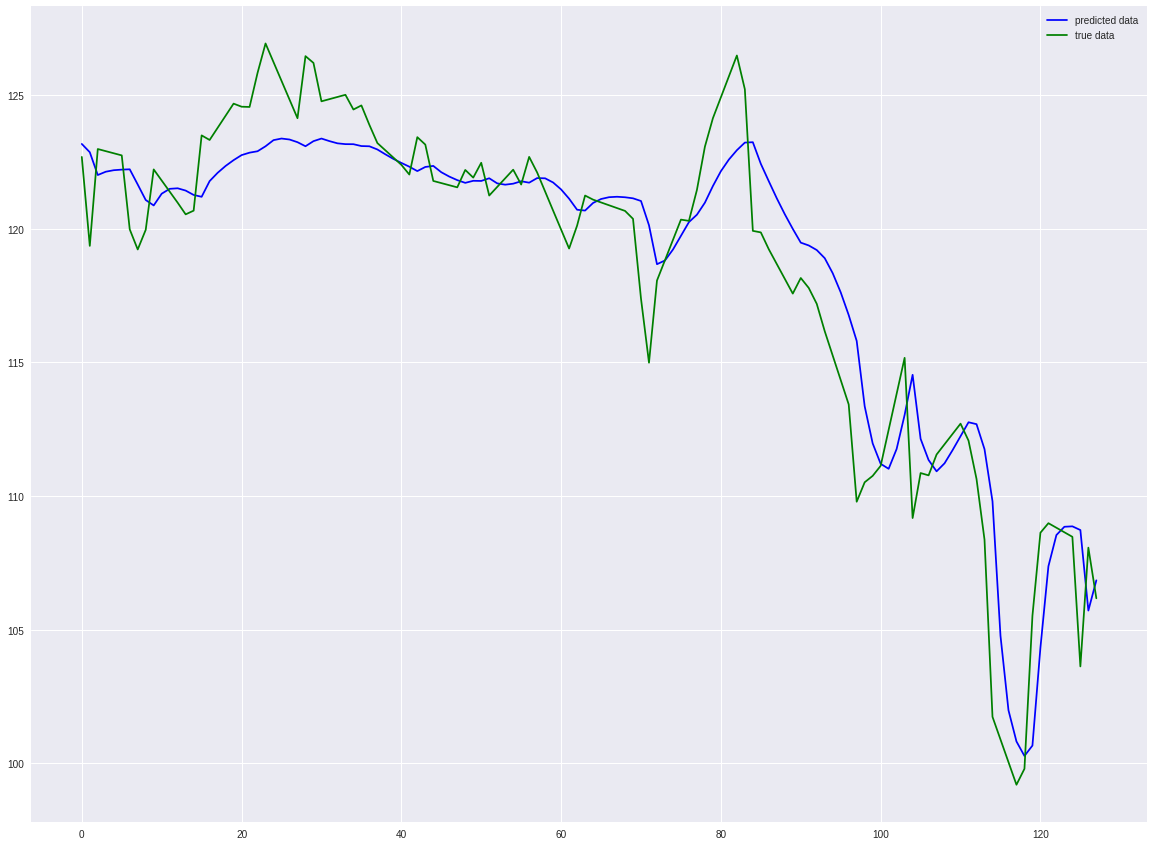

In [134]:
for i in range(test_batch_num - 1):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    plt.figure(figsize=(20, 15))
    plt.plot(range(batch_size), y_hat_arr[start_idx: end_idx], color='blue', label='predicted data')
    plt.plot(range(batch_size), y_labels_arr[start_idx: end_idx], color='green', label='true data')
    plt.draw()
    plt.legend()
